In [1]:
import time
import subprocess
import matplotlib.pyplot as plt
import psutil
import os
import re
import threading
import csv
import signal
import numpy as np
import math
import fcntl
import select
import stat

In [2]:
models = ["context_generator","DT_generator_c","DT_generator","IDT_generator","subroutine_generator","IDT_generator_c","context_generator_c","subroutine_generator_c"]

In [3]:
for model in models:
    subprocess.run(["clang++", "-std=c++20", model+".cpp", "-o", model])


In [4]:
directory = './grammars'
files = os.listdir(directory)
files.remove("simple_grammar.json")
files.remove("recursive.json")
print(files)

['math.json', 'css.json', 'html.json', 'regular_expression.json']


In [5]:
depth = [8,16,32,64,128]

In [6]:
result = {}
timeout = 10  # Timeout for each test in seconds

def set_non_blocking(fd):
    """Set the file descriptor to non-blocking mode."""
    flags = fcntl.fcntl(fd, fcntl.F_GETFL)
    fcntl.fcntl(fd, fcntl.F_SETFL, flags | os.O_NONBLOCK)

def ensure_executable(file_path):
    """Ensure the file is executable by the current user."""
    try:
        current_permissions = stat.S_IMODE(os.lstat(file_path).st_mode)
        os.chmod(file_path, current_permissions | stat.S_IXUSR | stat.S_IXGRP | stat.S_IXOTH)
    except OSError as e:
        print(f"Error setting executable permissions on {file_path}: {e}")

def safe_read(stream):
    """Safely read from a stream, handling potential errors."""
    try:
        chunk = stream.read(4096)
        if chunk is None:
            return b''
        return chunk
    except Exception as e:
        print(f"Error reading from stream: {e}")
        return b''

def compile_and_run(program_name, file_name, depth_value):
    filetype = ".c" if "_c" in program_name else ".fth"
    current_file_name = f"{program_name}_{depth_value}_{file_name}{filetype}"
    output_file = current_file_name[:-2] + ".out" if filetype == ".c" else current_file_name
    
    try:
        if filetype == ".c":
            # Compile C program
            subprocess.run(
                ["./"+program_name, "-p", f"./grammars/{file_name}", "-d", str(depth_value), "-o", current_file_name, "--endless"],
                check=True
            )
            subprocess.run(
                ["clang", current_file_name, "-O2", "-o", output_file],
                check=True
            )
            # Ensure the compiled file is executable
            ensure_executable(output_file)
            cmd = ["./" + output_file]
        else:
            # Compile Forth program
            subprocess.run(
                ["./"+program_name, "-p", f"./grammars/{file_name}", "-d", str(depth_value), "-o", current_file_name, "--endless"],
                check=True
            )
            cmd = ["gforth-fast", current_file_name, "-e", "bye"]

        # Check if we have permission to execute the file
        # if not os.access(cmd[0], os.X_OK):
        #     raise PermissionError(f"No execute permission for {cmd[0]}")
        print(f"Running {cmd}")
        process = subprocess.Popen(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            bufsize=0,  # Set bufsize to 0 to use unbuffered mode
            universal_newlines=False  # Use binary mode
        )

        set_non_blocking(process.stdout.fileno())
        set_non_blocking(process.stderr.fileno())

        start_time = time.time()
        total_bytes = 0

        while time.time() - start_time < timeout:
            ready, _, _ = select.select([process.stdout, process.stderr], [], [], 1)
            for stream in ready:
                chunk = safe_read(stream)
                total_bytes += len(chunk)

        # Check if the process is still running and terminate if necessary
        if process.poll() is None:
            process.terminate()
            try:
                process.wait(timeout=5)
            except subprocess.TimeoutExpired:
                process.kill()

    except subprocess.CalledProcessError as e:
        print(f"Error during compilation or execution: {e}")
        return 0
    except PermissionError as e:
        print(f"Permission error: {e}. Make sure you have the necessary permissions.")
        print(f"Current working directory: {os.getcwd()}")
        print(f"File exists: {os.path.exists(cmd[0])}")
        try:
            print(f"File permissions: {oct(os.stat(cmd[0]).st_mode)}")
        except OSError as stat_error:
            print(f"Error getting file permissions: {stat_error}")
        return 0
    except Exception as e:
        print(f"Unexpected error: {e}")
        print(f"Error type: {type(e).__name__}")
        return 0

    output_speed = total_bytes / timeout
    print(f"{program_name} {file_name} {depth_value} {output_speed:.2f} Bytes/s")
    return output_speed

# Main execution loop
for program_name in models:
    result[program_name] = {}
    for file_name in files:
        result[program_name][file_name] = {}
        for depth_value in depth:
            if "math" in file_name and depth_value > 64:
                continue
            output_speed = compile_and_run(program_name, file_name, depth_value)
            result[program_name][file_name][depth_value] = output_speed

print(result)

Code written to file successfully.
Running ['gforth-fast', 'context_generator_8_math.json.fth', '-e', 'bye']
context_generator math.json 8 6336102.40 Bytes/s
Code written to file successfully.
Running ['gforth-fast', 'context_generator_16_math.json.fth', '-e', 'bye']
context_generator math.json 16 5566054.40 Bytes/s
Code written to file successfully.
Running ['gforth-fast', 'context_generator_32_math.json.fth', '-e', 'bye']
context_generator math.json 32 5498880.00 Bytes/s
Code written to file successfully.
Running ['gforth-fast', 'context_generator_64_math.json.fth', '-e', 'bye']
context_generator math.json 64 5479219.20 Bytes/s
Code written to file successfully.
Running ['gforth-fast', 'context_generator_8_css.json.fth', '-e', 'bye']
context_generator css.json 8 12991283.20 Bytes/s
Code written to file successfully.
Running ['gforth-fast', 'context_generator_16_css.json.fth', '-e', 'bye']
context_generator css.json 16 6912819.20 Bytes/s
Code written to file successfully.
Running ['gf

In [7]:
## convert the result in MB/s
for i in range(len(models)):
    program_name = models[i]
    for j in range(len(files)):
        file_name = files[j]
        for k in range(len(depth)):
            depth_value = depth[k]
            if program_name in result and file_name in result[program_name] and depth_value in result[program_name][file_name]:
                result[program_name][file_name][depth_value] = result[program_name][file_name][depth_value] / 1024 / 1024


In [8]:
# Save the result in a csv file
with open('results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Program', 'File', 'Depth', 'Average Throughput Rate (MB/s)'])
    for program_name, files_dict in result.items():
        for file_name, depths_dict in files_dict.items():
            for depth_value, avg_throughput_rate in depths_dict.items():
                writer.writerow([program_name, file_name, depth_value, avg_throughput_rate])

print("Results have been written to results.csv")


Results have been written to results.csv


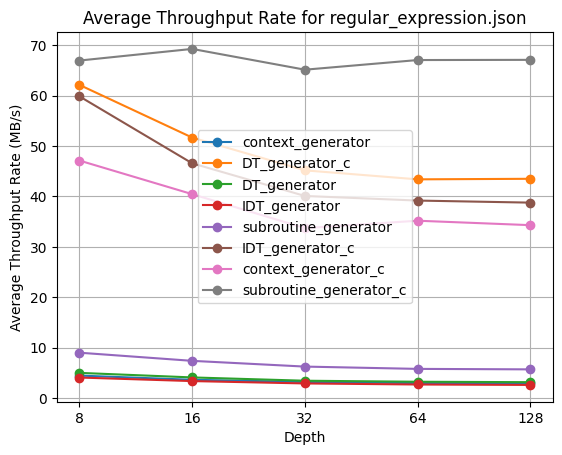

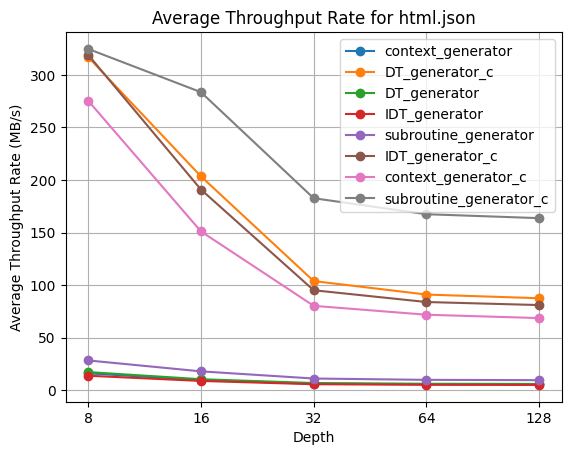

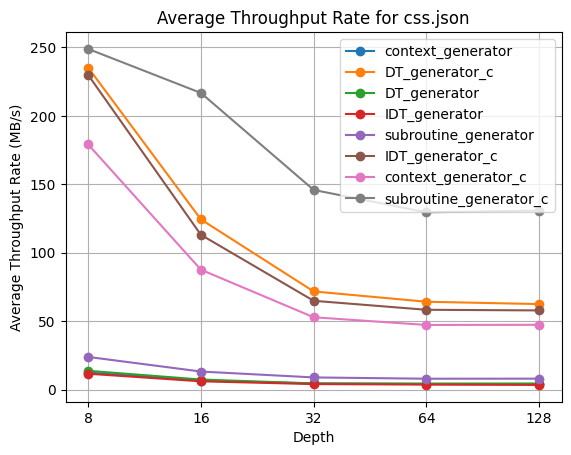

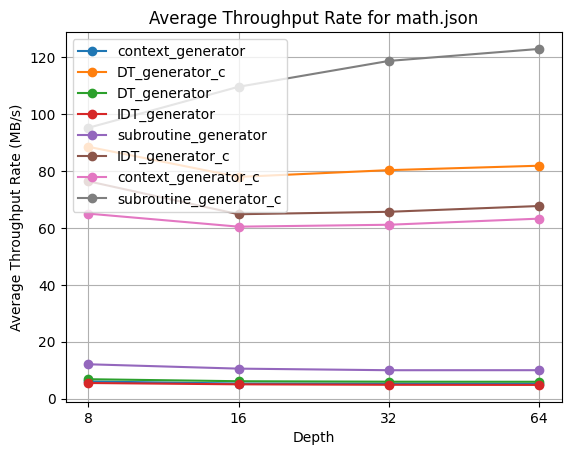

In [9]:
csv_filename = 'results.csv'

results = {}

with open(csv_filename, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        program_name = row['Program']
        file_name = row['File']
        dp = int(row['Depth'])
        avg_throughput_rate = float(row['Average Throughput Rate (MB/s)'])

        if program_name not in results:
            results[program_name] = {}
        if file_name not in results[program_name]:
            results[program_name][file_name] = {}

        if dp not in results[program_name][file_name]:
            results[program_name][file_name][dp] = []
        
        results[program_name][file_name][dp].append(avg_throughput_rate)

for file_name in {file_name for program_data in results.values() for file_name in program_data.keys()}:
    plt.figure()
    for program_name in results.keys():
        if file_name in results[program_name]:
            depths = sorted(results[program_name][file_name].keys())
            rates = [results[program_name][file_name][d] for d in depths]
            plt.plot([math.log(x,2) for x in depths], rates, marker='o', label=program_name)
    
    plt.xlabel('Depth')
    plt.ylabel('Average Throughput Rate (MB/s)')
    plt.title(f'Average Throughput Rate for {file_name}')
    plt.legend()
    plt.grid(True)

    plt.xticks([math.log(x,2) for x in depths], [str(d) for d in depths])

    plt.savefig(f"./result/{file_name}_throughput.png")
    plt.show()

In [10]:

import glob

current_directory = os.getcwd()
files = glob.glob(os.path.join(current_directory, '*.fth'))
files += glob.glob(os.path.join(current_directory, '*.c'))
files += glob.glob(os.path.join(current_directory, '*.out'))
for file in files:
    try:
        os.remove(file)
        print(f'Deleted: {file}')
    except Exception as e:
        print(f'Error deleting {file}: {e}')


Deleted: /Users/apple/gForthVM/subroutine_generator_8_html.json.fth
Deleted: /Users/apple/gForthVM/context_generator_32_math.json.fth
Deleted: /Users/apple/gForthVM/context_generator_16_html.json.fth
Deleted: /Users/apple/gForthVM/IDT_generator_32_regular_expression.json.fth
Deleted: /Users/apple/gForthVM/subroutine_generator_128_css.json.fth
Deleted: /Users/apple/gForthVM/IDT_generator_8_html.json.fth
Deleted: /Users/apple/gForthVM/subroutine_generator_16_regular_expression.json.fth
Deleted: /Users/apple/gForthVM/IDT_generator_32_html.json.fth
Deleted: /Users/apple/gForthVM/subroutine_generator_64_html.json.fth
Deleted: /Users/apple/gForthVM/IDT_generator_16_math.json.fth
Deleted: /Users/apple/gForthVM/DT_generator_8_math.json.fth
Deleted: /Users/apple/gForthVM/DT_generator_32_math.json.fth
Deleted: /Users/apple/gForthVM/context_generator_32_regular_expression.json.fth
Deleted: /Users/apple/gForthVM/DT_generator_8_regular_expression.json.fth
Deleted: /Users/apple/gForthVM/IDT_generato